# Mar-?-2021 (corr ca)

**Motivation**: Correlation/network analysis on Ca data.  Simple network measures and (non-overlapping) community detection.<br>
**Results**:  

In [1]:
# HIDE CODE


import re
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.stats import pearsonr
from os.path import join as pjoin
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

base_dir = '/home/hadi/Documents/data'
raw_dir = pjoin(base_dir, 'raw')
processed_dir = pjoin(base_dir, 'processed')
os.makedirs(processed_dir, exist_ok=True)

### Process data

In [2]:
# HIDE CODE


shared_names = []
for i in Path(raw_dir).glob('**/*.gz'):
    meta = i.name.split('_')
    sub = next(filter(lambda x: 'sub' in x, meta))
    ses = next(filter(lambda x: 'ses' in x, meta))
    run = next(filter(lambda x: 'run' in x, meta))
    task = next(filter(lambda x: 'task' in x, meta))
    shared_names.append('_'.join([sub, ses, task, run]))
shared_names = sorted(list(np.unique(shared_names)))

# process and save files
for keyword in tqdm(shared_names):
    selected_files = list(map(lambda x: str(x), Path(raw_dir).glob('**/*{:s}*.gz'.format(keyword))))
    try:
        bold_load_file = next(filter(lambda x: 'bold' in x, selected_files))
    except StopIteration:
        continue

    meta = bold_load_file.split('/')[-1].split('_')
    sub = next(filter(lambda x: 'sub' in x, meta))
    ses = next(filter(lambda x: 'ses' in x, meta))
    run = next(filter(lambda x: 'run' in x, meta))
    task = next(filter(lambda x: 'task' in x, meta))
    key = '_'.join([sub, ses, run, task])

    # bold
    bold_save_file = pjoin(processed_dir, key + '_bold.npy')
    try:
        with open(bold_load_file) as f:
            data = nib.load(f.name).get_fdata()
        np.save(bold_save_file, data)
    except FileNotFoundError:
        print('Warning! file not found:\n{:s}'.format(bold_load_file))
        continue

    # ca
    ca_load_files = sorted([item for item in selected_files if 'ca' in item])
    ca_data_list = []
    for ca_file in ca_load_files:
        try:
            with open(ca_file) as f:
                ca_data_list.append(nib.load(f.name).get_fdata())
        except FileNotFoundError:
            print('Warning! file not found: {:s}'.format(ca_file))
    
    data = np.concatenate(ca_data_list, axis=-1)
    save_filename = pjoin(processed_dir, key + '_ca.npy')
    np.save(save_filename, data)


In [3]:
_dir = '/home/hadi/Documents/data/raw/sub-SLC06/ses-1/ca2'

In [4]:
sorted([item for item in os.listdir(_dir) if 'run-7' in item])

['sub-SLC06_ses-1_task-rest_run-7_part-1_space-individual_desc-preproc_ca2.nii.gz',
 'sub-SLC06_ses-1_task-rest_run-7_part-2_space-individual_desc-preproc_ca2.nii.gz',
 'sub-SLC06_ses-1_task-rest_run-7_part-3_space-individual_desc-preproc_ca2.nii.gz']

In [5]:
f1 = pjoin(_dir, 'sub-SLC06_ses-1_task-rest_run-7_part-1_space-individual_desc-preproc_ca2.nii.gz')
f2 = pjoin(_dir, 'sub-SLC06_ses-1_task-rest_run-7_part-2_space-individual_desc-preproc_ca2.nii.gz')
f3 = pjoin(_dir, 'sub-SLC06_ses-1_task-rest_run-7_part-3_space-individual_desc-preproc_ca2.nii.gz')
data1 = nib.load(f1).get_fdata()
data2 = nib.load(f2).get_fdata()
data3 = nib.load(f3).get_fdata()

In [6]:
data1.shape, data2.shape, data3.shape

((256, 250, 1, 2090), (256, 250, 1, 2089), (256, 250, 1, 1821))

In [10]:
data = np.concatenate([data1, data2, data3], axis=-1)[..., 0, :]
data.shape

(256, 250, 6000)

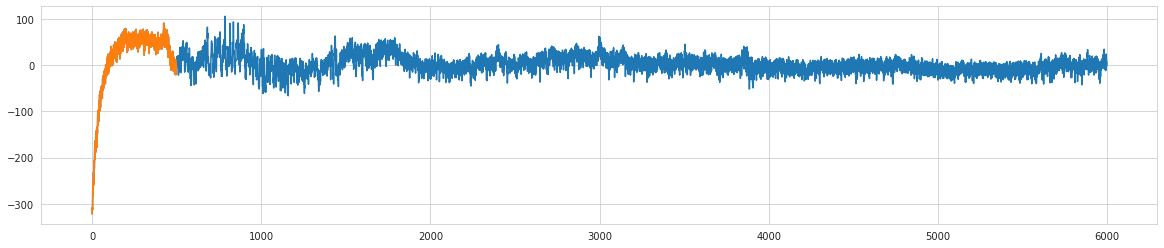

In [14]:
plt.figure(figsize=(20, 4))
plt.plot(data.mean(0).mean(0))
plt.plot(data.mean(0).mean(0)[:500])

## Plots of Ca traces

Just like before, I'm plotting all traces to visually inspect quality.  These data that I selected for the analysis did not have the preprocessing error.

----------------------------------------------------------------------------------------------------


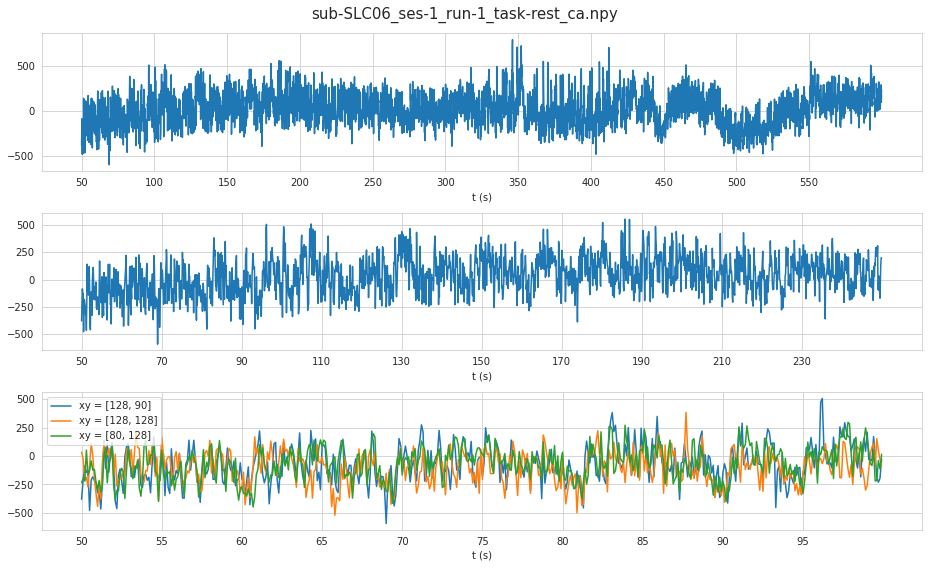

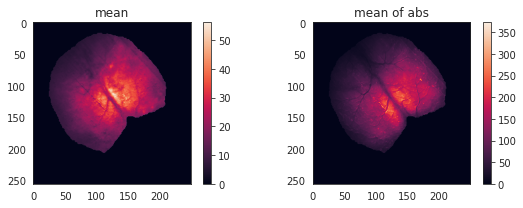

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


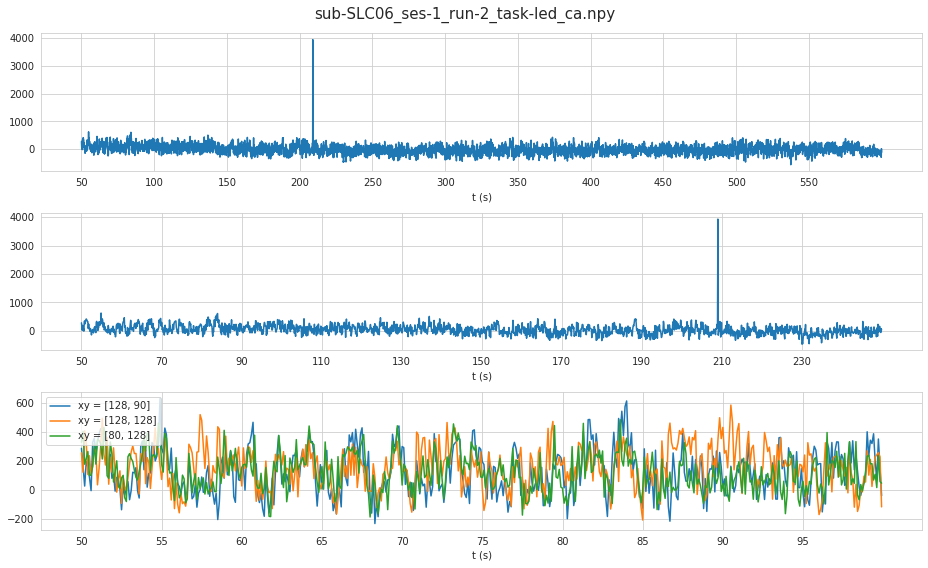

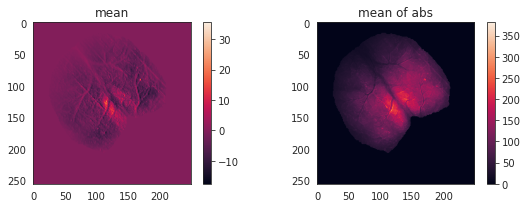

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


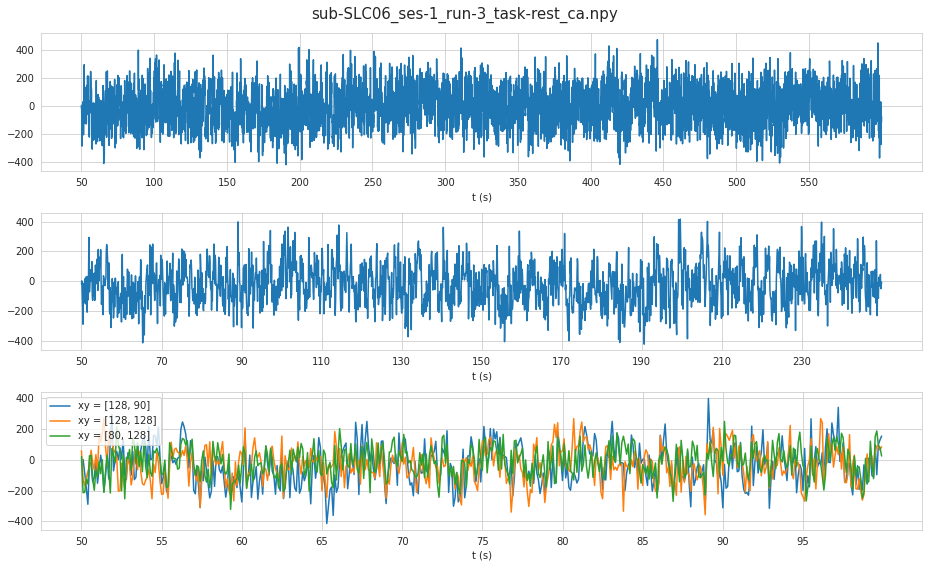

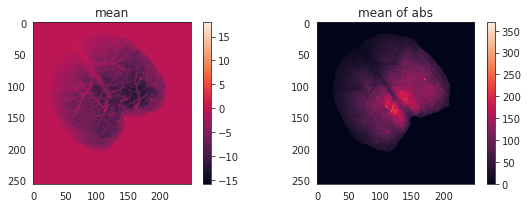

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


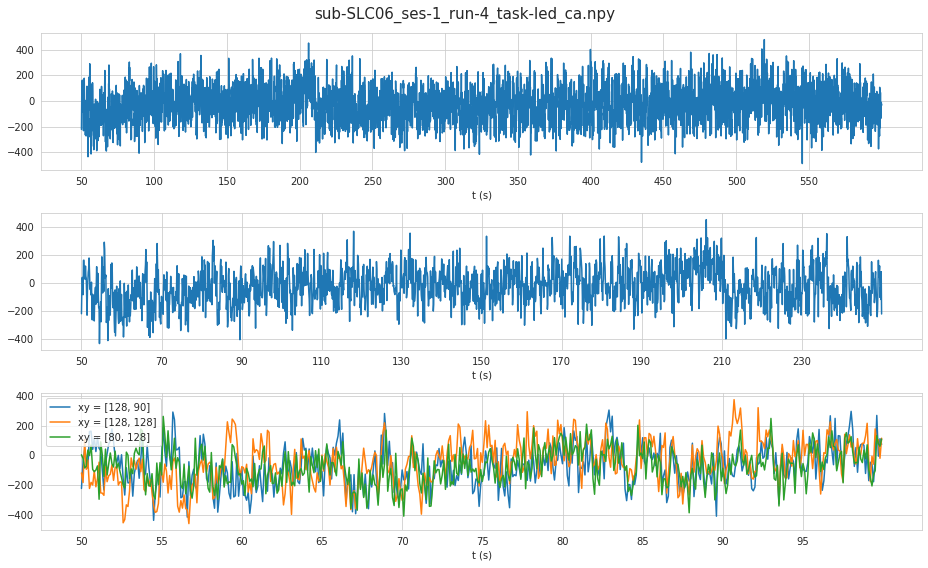

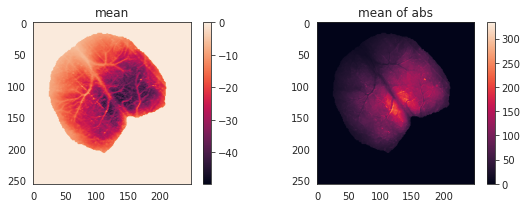

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


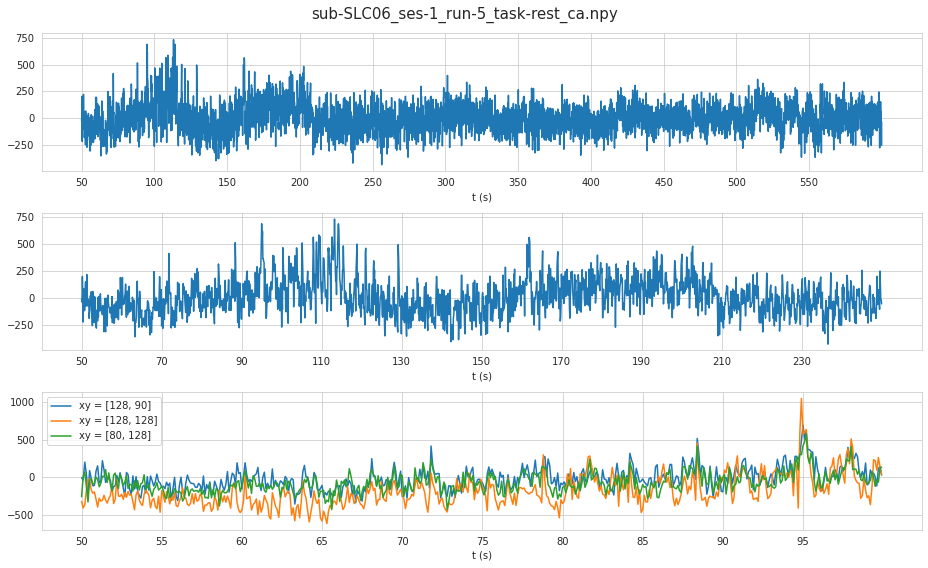

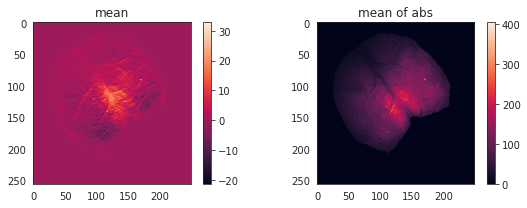

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


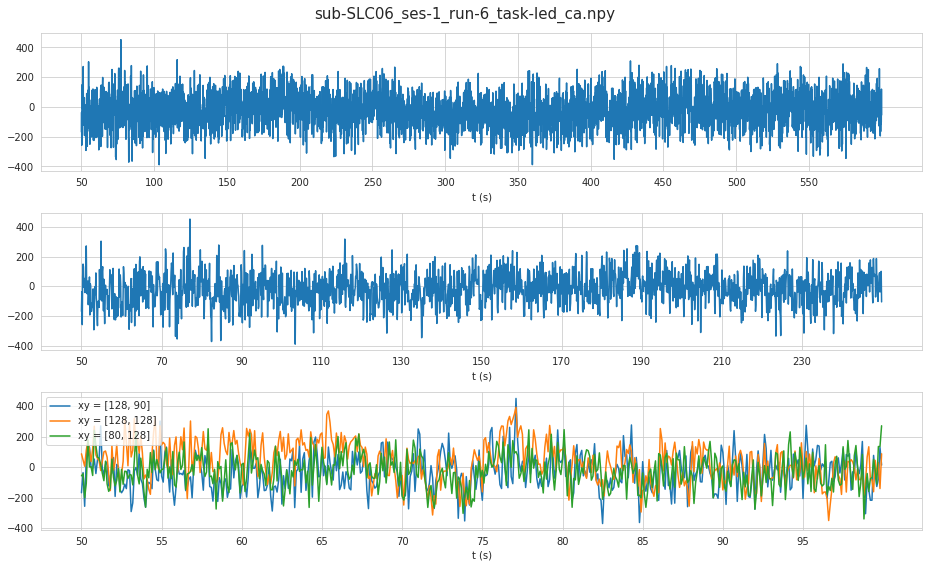

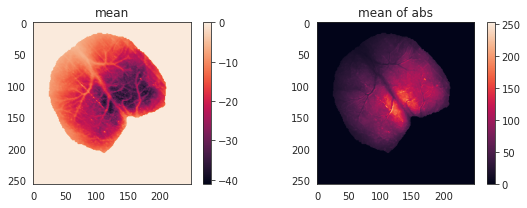

---------------------------------------------------------------------------------------------------- 




----------------------------------------------------------------------------------------------------


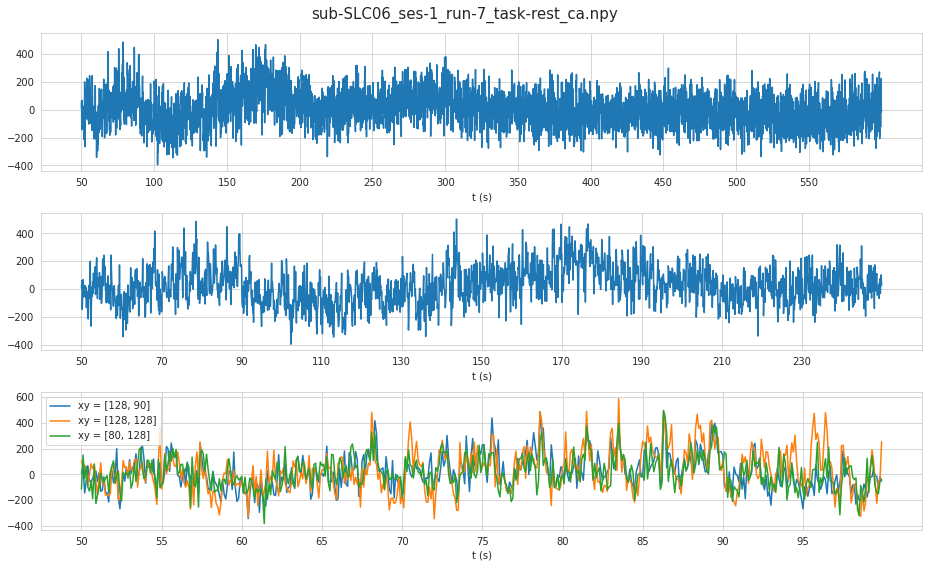

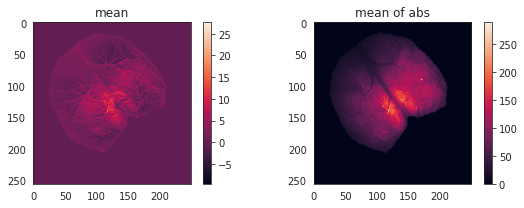

---------------------------------------------------------------------------------------------------- 






In [34]:
# HIDE CODE



expt_duration = 600   # 600 seconds
ca_frequency = 10
exclude_seconds = 50

filter_fn = lambda x: 'ca' in x and 'ses-1' in x
for load_filename in sorted(filter(filter_fn, os.listdir(processed_dir))):
    ca = np.load(pjoin(processed_dir, load_filename), mmap_mode='r')
    
    start = ca.shape[-1] - ((expt_duration - exclude_seconds) * ca_frequency)
    end = ca.shape[-1]
    
    # print("file name:  {:s}\tshape:  {}\ttrange included:  {}"
     #     .format(load_filename, ca.shape, [start, end]))
    trange = range(start, end)
    ca = ca[..., 0, trange]

    print('-' * 100)
    
    sns.set_style('whitegrid')
    plt.figure(figsize=(13, 8))
    
    plt.subplot(311)
    intvl = range(0, end - start)
    xticks = [item for item in intvl if item % (len(intvl) // 11) == 0]
    xtick_labels = [(item + start) // ca_frequency for item in xticks]
    plt.plot(ca[128, 90, intvl])
    plt.xticks(xticks, xtick_labels)
    plt.xlabel('t (s)')
    
    plt.subplot(312)
    intvl = range(0, 2000)
    xticks = [item for item in intvl if item % (len(intvl) // 10) == 0]
    xtick_labels = [(item + start) // ca_frequency for item in xticks]
    plt.plot(ca[128, 90, intvl])
    plt.xticks(xticks, xtick_labels)
    plt.xlabel('t (s)')
    
    plt.subplot(313)
    intvl = range(0, 500)
    xticks = [item for item in intvl if item % (len(intvl) // 10) == 0]
    xtick_labels = [(item + start) // ca_frequency for item in xticks]
    plt.plot(ca[128, 90, intvl], label='xy = [128, 90]')
    plt.plot(ca[128, 128, intvl], label='xy = [128, 128]')
    plt.plot(ca[80, 128, intvl], label='xy = [80, 128]')
    plt.xticks(xticks, xtick_labels)
    plt.xlabel('t (s)')
    plt.legend(loc='upper left')
    
    plt.suptitle(load_filename, fontsize=15)
    plt.tight_layout()
    plt.show()
    
    
    sns.set_style('white')
    plt.figure(figsize=(8, 3))

    plt.subplot(121)
    plt.imshow(ca.mean(-1))
    plt.colorbar()
    plt.title('mean')

    plt.subplot(122)
    plt.imshow(np.abs(ca).mean(-1))
    plt.colorbar()
    plt.title('mean of abs')

    plt.tight_layout()
    plt.show()
    
    print('-' * 100, '\n\n\n\n')